In [ ]:
# Instala la herramienta Consola del archivo ISIC
!pip install isic-cli #Sacada desde el repositorio de Github https://github.com/ImageMarkup/isic-cli/blob/master/README.md

# Se actualizan las librerías a versiones compatibles para resolver los conflictos.
!pip install tensorflow==2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
#Descargar Imagenes + Metadatos
!isic image download --search "" --collections "249" --limit 0 BCN20000/ # Imagenes y Metadatos de BCN20000

#Comando extraido desde la misma ISIC ARCHIVE https://api.isic-archive.com/images/?query=&collections=249

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 18,946 images to BCN20000/.
Successfully wrote 18,946 metadata records to BCN20000/metadata.csv.
Successfully wrote attributions to BCN20000/attribution.txt.
Successfully wrote 1 license(s) to BCN20000/licenses.


In [ ]:
import csv
from collections import defaultdict

def cargar_metadatos_malignos(archivo, diagnosis_col_name='diagnosis_3'):

    # Definir las únicas clases que nos interesan
    # (Esta es la lista de tus diagnósticos malignos)
    CLASES_VALIDAS = {'Melanoma, NOS', 'Basal cell carcinoma', 'Squamous cell carcinoma, NOS', 'Melanoma metastasis'}

    ids_por_clase = defaultdict(list)

    try:
        with open(archivo, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader) # Lee la fila de encabezado

            # Busca dinámicamente las columnas
            try:
                id_col_idx = header.index('isic_id')
                diagnosis_col_idx = header.index(diagnosis_col_name)
            except ValueError as e:
                print(f"Error: No se encontró la columna requerida ('{e.args[0]}') en el archivo CSV.")
                return None

            # Leer y filtrar
            for fila in reader:
                if len(fila) > diagnosis_col_idx and len(fila) > id_col_idx:
                    diagnosis = fila[diagnosis_col_idx].strip()
                    isic_id = fila[id_col_idx]

                    # Si el diagnóstico está en nuestra lista de deseados
                    if diagnosis in CLASES_VALIDAS:
                        ids_por_clase[diagnosis].append(isic_id)

        print("Datos extraídos y filtrados por clase (Malignos):")
        total_registros = 0
        for clase, ids in ids_por_clase.items():
            print(f"  - {clase}: {len(ids)} imágenes")
            total_registros += len(ids)
        print(f"Total de registros válidos: {total_registros}")

        return ids_por_clase

    except FileNotFoundError:
        print(f"Error: Archivo {archivo} no encontrado")
        return None
    except Exception as e:
        print(f"Error al procesar el archivo: {e}")
        return None

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def organizar_imagenes_en_carpetas(carpeta_origen, ids_por_clase, carpeta_destino_base, test_size=0.3, random_state=42):

    # Función auxiliar para copiar archivos
    def copiar_archivos(ids, carpeta_destino):
        """ Copia una lista de IDs de imagen a una carpeta de destino. """
        os.makedirs(carpeta_destino, exist_ok=True)
        for id_img in tqdm(ids, desc=f'Copiando a {os.path.basename(carpeta_destino)}'):
            nombre_archivo = f"{id_img}.jpg" # Asume extensión .jpg
            ruta_origen = os.path.join(carpeta_origen, nombre_archivo)
            ruta_destino = os.path.join(carpeta_destino, nombre_archivo)

            if os.path.exists(ruta_origen):
                shutil.copy(ruta_origen, ruta_destino)
            else:
                print(f"Advertencia: No se encontró el archivo {ruta_origen}")


    if not ids_por_clase:
        print("No se proporcionaron datos (ids_por_clase está vacío). No se copiarán archivos.")
        return

    nombres_de_clases = list(ids_por_clase.keys())

    for clase_nombre in nombres_de_clases:
        print(f"\nProcesando clase: {clase_nombre}")

        ids_de_esta_clase = ids_por_clase[clase_nombre]

        # Divide los IDs de x clase en train y test
        try:
            ids_train, ids_test = train_test_split(
                ids_de_esta_clase,
                test_size=test_size,
                random_state=random_state
            )
        except ValueError:
            print(f"Advertencia: No hay suficientes imágenes en la clase '{clase_nombre}' para dividir. Omitiendo.")
            continue

        # Define rutas de destino dinámicamente
        ruta_train = os.path.join(carpeta_destino_base, 'train', clase_nombre)
        ruta_test = os.path.join(carpeta_destino_base, 'test', clase_nombre)

        # Copiar los archivos
        print(f"Copiando {clase_nombre} (train)...")
        copiar_archivos(ids_train, ruta_train)

        print(f"Copiando {clase_nombre} (test)...")
        copiar_archivos(ids_test, ruta_test)

    print("\nImágenes organizadas correctamente en carpetas de clase (multiclase).")

In [ ]:
import os
import shutil

# Eliminar el directorio del dataset antiguo para evitar conflictos y asegurar una regeneración limpia
if os.path.exists('/content/dataset'):
    shutil.rmtree('/content/dataset')
    print("Directorio '/content/dataset' anterior eliminado.")
else:
    print("El directorio '/content/dataset' no existía, no fue necesaria ninguna limpieza.")

El directorio '/content/dataset' no existía, no fue necesaria ninguna limpieza.


In [ ]:
# Asumiendo que los metadatos ya han sido cargados correctamente
metadatos = cargar_metadatos_malignos("/content/BCN20000/metadata.csv")

Datos extraídos y filtrados por clase (Malignos):
  - Melanoma, NOS: 4003 imágenes
  - Squamous cell carcinoma, NOS: 559 imágenes
  - Basal cell carcinoma: 3676 imágenes
  - Melanoma metastasis: 633 imágenes
Total de registros válidos: 8871


In [ ]:
organizar_imagenes_en_carpetas('/content/BCN20000/', metadatos, '/content/dataset')


Procesando clase: Melanoma, NOS
Copiando Melanoma, NOS (train)...


Copiando a Melanoma, NOS: 100%|██████████| 2802/2802 [00:00<00:00, 3287.14it/s]


Copiando Melanoma, NOS (test)...


Copiando a Melanoma, NOS: 100%|██████████| 1201/1201 [00:00<00:00, 2475.76it/s]



Procesando clase: Squamous cell carcinoma, NOS
Copiando Squamous cell carcinoma, NOS (train)...


Copiando a Squamous cell carcinoma, NOS: 100%|██████████| 391/391 [00:00<00:00, 1851.76it/s]


Copiando Squamous cell carcinoma, NOS (test)...


Copiando a Squamous cell carcinoma, NOS: 100%|██████████| 168/168 [00:00<00:00, 2967.39it/s]



Procesando clase: Basal cell carcinoma
Copiando Basal cell carcinoma (train)...


Copiando a Basal cell carcinoma: 100%|██████████| 2573/2573 [00:01<00:00, 1699.48it/s]


Copiando Basal cell carcinoma (test)...


Copiando a Basal cell carcinoma: 100%|██████████| 1103/1103 [00:00<00:00, 1640.18it/s]



Procesando clase: Melanoma metastasis
Copiando Melanoma metastasis (train)...


Copiando a Melanoma metastasis: 100%|██████████| 443/443 [00:00<00:00, 1724.41it/s]


Copiando Melanoma metastasis (test)...


Copiando a Melanoma metastasis: 100%|██████████| 190/190 [00:00<00:00, 1691.94it/s]


Imágenes organizadas correctamente en carpetas de clase (multiclase).


In [ ]:
#Para Lesiones Malignas

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

L2_REG = 1e-5

def Arq2_MALIGNA(input_shape=(224, 224, 3), num_classes=4):


    if num_classes < 2:
        raise ValueError("num_classes debe ser 2 o más para sparse_categorical_crossentropy")

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Bloque 1
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False), # Bias innecesario antes de BN
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 2
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        # Bloque 3
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_REG),
                      use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Cabezal de Clasificación

        layers.GlobalAveragePooling2D(),

        layers.BatchNormalization(),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(L2_REG)),
        layers.Dropout(0.5),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Creación del modelo
Modelo_2_MALIGNA = Arq2_MALIGNA()

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def crear_generadores(carpeta_destino_base, batch_size=32):
    #Configuración MODERADA: Probada exitosamente para preservar geometría de lesiones.

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        # Aumentación Moderada
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=5,
        zoom_range=[0.9, 1.1],
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(carpeta_destino_base, 'train'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=True
    )

    validation_generator = test_datagen.flow_from_directory(
        os.path.join(carpeta_destino_base, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False # Crucial para validación
    )

    return train_generator, validation_generator

train_generator, validation_generator = crear_generadores('/content/dataset')

Found 6209 images belonging to 4 classes.
Found 2662 images belonging to 4 classes.


In [ ]:
!pip install focal-loss

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from focal_loss import SparseCategoricalFocalLoss

# Calcular Pesos
y_true = train_generator.classes
clases_unicas = np.unique(y_true)

weights_array = compute_class_weight(
    class_weight='balanced',
    classes=clases_unicas,
    y=y_true
)
weights_dict = dict(enumerate(weights_array))
alpha_weights = [weights_dict[i] for i in sorted(weights_dict.keys())]

print("Pesos calculados (Alpha):", alpha_weights)

# Configuración de Optimizador y Loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
loss_fn = SparseCategoricalFocalLoss(gamma=1.0, class_weight=alpha_weights)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Compilar
Modelo_2_MALIGNA.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

print("Modelo Maligno compilado y listo.")

Pesos calculados (Alpha): [np.float64(0.6032841041585698), np.float64(3.5039503386004514), np.float64(0.5539793004996431), np.float64(3.9699488491048593)]
Modelo Maligno compilado y listo.


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ReduceLROnPlateau

csv_logger_2_Mal = CSVLogger('registro_entrenamiento_modelo_Maligno.csv', separator=',', append=False)

In [ ]:
#Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

history = Modelo_2_MALIGNA.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[csv_logger_2_Mal, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 169s 693ms/step - accuracy: 0.2970 - loss: 1.3341 - val_accuracy: 0.4842 - val_loss: 1.0588 - learning_rate: 1.0000e-04
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 641ms/step - accuracy: 0.4277 - loss: 1.0562 - val_accuracy: 0.4857 - val_loss: 0.9063 - learning_rate: 1.0000e-04
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 122s 625ms/step - accuracy: 0.4623 - loss: 0.9776 - val_accuracy: 0.5154 - val_loss: 0.8215 - learning_rate: 1.0000e-04
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 123s 633ms/step - accuracy: 0.4688 - loss: 0.8911 - val_accuracy: 0.5267 - val_loss: 0.8175 - learning_rate: 1.0000e-04
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.4936 - loss: 0.8712 - val_accuracy: 0.5624 - val_loss: 1.0728 - learning_rate: 1.0000e-04
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 126s 647ms/step - accuracy: 0.4747 - loss: 0.8962 - val_accuracy: 0.4838 - val_loss: 0.8023 - learning_rate: 1.0000e-04
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 

--- Iniciando Auditoría Final (Dataset Maligno) ---
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step

Reporte de Clasificación Detallado (Maligno):
                              precision    recall  f1-score   support

        Basal cell carcinoma       0.73      0.53      0.62      1103
         Melanoma metastasis       0.30      0.48      0.37       190
               Melanoma, NOS       0.86      0.74      0.79      1201
Squamous cell carcinoma, NOS       0.18      0.56      0.27       168

                    accuracy                           0.62      2662
                   macro avg       0.52      0.58      0.51      2662
                weighted avg       0.73      0.62      0.66      2662



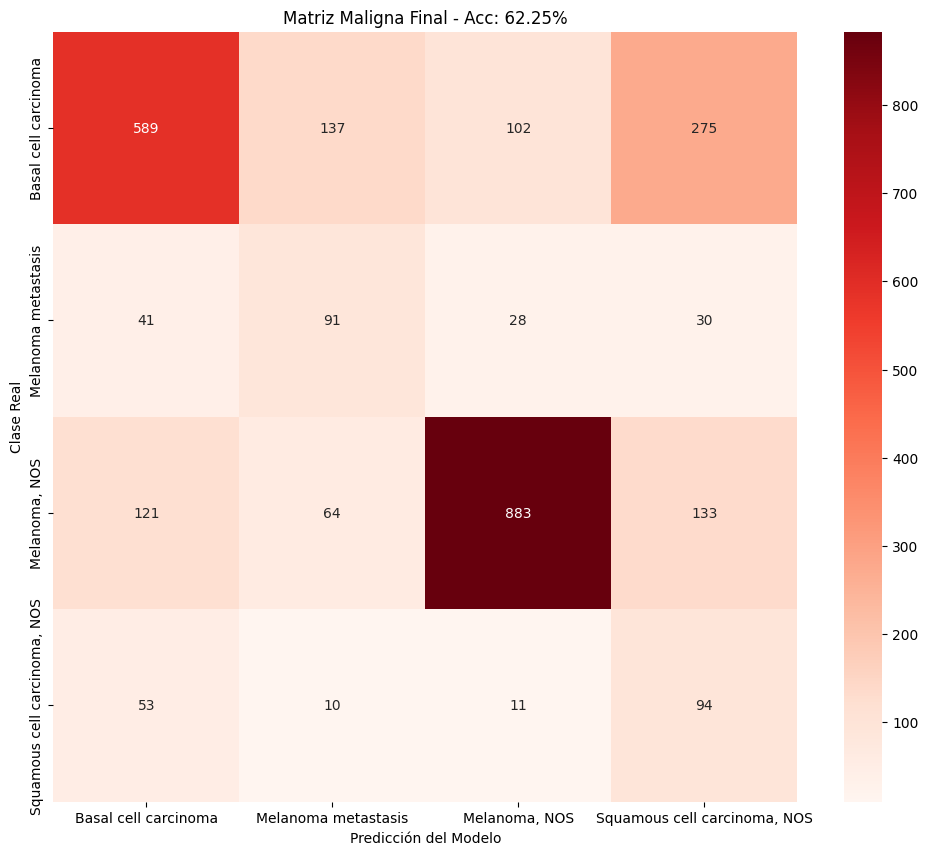

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definimos explícitamente qué modelo y generador evaluar
target_model = Modelo_2_MALIGNA       # El modelo de 4 clases
target_generator = validation_generator     # El generador de validación maligno

# Reiniciar Generador y Predecir
print("--- Iniciando Auditoría Final (Dataset Maligno) ---")
target_generator.reset()

Y_pred = target_model.predict(target_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = target_generator.classes

# Reporte Texto
class_names = list(target_generator.class_indices.keys())
print("\nReporte de Clasificación Detallado (Maligno):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusión Gráfica
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción del Modelo')
plt.ylabel('Clase Real')
plt.title(f'Matriz Maligna Final - Acc: {100*np.sum(y_pred==y_true)/len(y_true):.2f}%')
plt.show()

In [ ]:
import os

# Crear la carpeta para guardar los modelos si no existe
os.makedirs('/content/MisModelos', exist_ok=True)

# Guardar los modelos entrenados
print("Guardando modelo...")
Modelo_2_MALIGNA.save('/content/MisModelos/Modelo_2_Maligno.h5')

print("Modelos guardados exitosamente en /content/MisModelos/")

Guardando modelo...
Modelos guardados exitosamente en /content/MisModelos/


In [ ]:
from google.colab import files
import os

# Ruta del modelo específico que se guardó en la celda anterior
modelo_path = '/content/MisModelos/Modelo_2_Maligno.h5'

print(f"Intentando descargar el modelo: {os.path.basename(modelo_path)}")

if os.path.exists(modelo_path):
    files.download(modelo_path)
    print("\nDescarga completada exitosamente.")
else:
    print(f"\nError: No se encontró el archivo del modelo en la ruta especificada: {modelo_path}")
    print("Por favor, asegúrate de que la celda anterior para guardar el modelo se haya ejecutado sin errores.")

Intentando descargar el modelo: Modelo_2_Maligno.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Descarga completada exitosamente.


In [ ]:
import pandas as pd
import os

def convertir_csv_a_excel(ruta_csv, ruta_excel):

    if not os.path.exists(ruta_csv):
        print(f"Advertencia: El archivo CSV no fue encontrado en la ruta: {ruta_csv}")
        return False

    try:
        # Lee el archivo CSV con pandas
        df = pd.read_csv(ruta_csv)

        # Guarda el DataFrame como archivo Excel
        df.to_excel(ruta_excel, index=False)

        print(f"Métricas de '{ruta_csv}' guardadas exitosamente en: {ruta_excel}")
        return True

    except Exception as e:
        print(f"Error durante la conversión de '{ruta_csv}' a Excel: {e}")
        return False

In [ ]:
from google.colab import files

# Lista de los archivos CSV de registro que se generaron
archivos_csv_registros = [
    'registro_entrenamiento_modelo_Maligno.csv'
]

# Carpeta para guardar los archivos Excel
carpeta_excel = '/content/Metricas_Excel/'
os.makedirs(carpeta_excel, exist_ok=True)

print("--- Iniciando conversión y descarga de métricas ---")
for nombre_csv in archivos_csv_registros:
    nombre_excel = nombre_csv.replace('.csv', '.xlsx')
    ruta_excel_destino = os.path.join(carpeta_excel, nombre_excel)

    # Intentar convertir el archivo
    if convertir_csv_a_excel(nombre_csv, ruta_excel_destino):
        # Si la conversión fue exitosa, descargar el archivo
        print(f"Iniciando descarga de {ruta_excel_destino}...")
        files.download(ruta_excel_destino)

print("\n--- Proceso de conversión y descarga finalizado. ---")

--- Iniciando conversión y descarga de métricas ---
Métricas de 'registro_entrenamiento_modelo_Maligno.csv' guardadas exitosamente en: /content/Metricas_Excel/registro_entrenamiento_modelo_Maligno.xlsx
Iniciando descarga de /content/Metricas_Excel/registro_entrenamiento_modelo_Maligno.xlsx...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Proceso de conversión y descarga finalizado. ---
